### Import Libraries

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from nltk.tokenize import word_tokenize
import csv
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer, \
HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
import itertools
from sklearn.model_selection import validation_curve, ShuffleSplit, learning_curve

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import data

In [4]:
def read_data(data_dir):
    """
    Fuction loads data in csv format
    @data_dir: path of the dataset to be imported
    @return: data in csv format
    """
    data = pd.read_csv(data_dir)
    print('Shape of the dataset: ', data.shape)
    print('Dataset columns: ', data.columns)
    print('\n')
    return data
     

In [5]:
# data directory paths
train_data_dir = 'data/train.csv'
test_data_dir = 'data/test.csv'

train_data = read_data(train_data_dir)
test_data = read_data(test_data_dir)

Shape of the dataset:  (1306122, 3)
Dataset columns:  Index(['qid', 'question_text', 'target'], dtype='object')


Shape of the dataset:  (375806, 2)
Dataset columns:  Index(['qid', 'question_text'], dtype='object')




In [6]:
# Print top 5 records (train data)
train_data.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
# Print top 5 records (test data)
test_data.head(5)

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


### Text Preprocessing

##### Train Data

In [96]:
train_question, train_targets = train_data[['question_text']].values, train_data['target'].values

In [97]:
train_question.shape, train_targets.shape

((1306122, 1), (1306122,))

##### Split Data

In [98]:
def split_data(X, t):
    """
    Function shuffles dataset and splits input features and labels
    into train and test datasets using 80-20 ratio.
    @input_features_data: news articles data
    @labels_data: corrospoinding labels of the news articles
    @return returns data splitted into train and test datasets
    """
    # Shuffling data indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    t = t[indices]
        
    # 80% of training samples and 20% of validation samples
    train_counts = (len(X)*80)//100
    
    # split dataset into train and test datasets
    # training data
    X_train = X[:train_counts]
    t_train = t[:train_counts]

    # testing data
    X_test = X[train_counts:]
    t_test = t[train_counts:]
    
    return X_train, t_train, X_test, t_test

In [99]:
# Further Split train dataset into train and validation datasets
train_questions_texts, train_targets, val_questions_texts, val_targets = split_data(train_question, train_targets)

In [104]:
# Training Dataset
train_questions_texts.shape, train_targets.shape

((1044897, 1), (1044897,))

In [103]:
# Vaidation Dataset
val_questions_texts.shape, val_targets.shape

((261225, 1), (261225,))

#### Test Data

In [108]:
test_questions_texts= test_data[['question_text']].values

In [109]:
test_questions_texts.shape

(375806, 1)

#### Clean text data

In [36]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [105]:
def remove_stopwords(text):
    """
    Function to truncate stopwrds from the given string
    @text: a string to remove stopwords from
    @ return: returns a modified string
    """
    text = [word for word in text.split() if word not in STOPWORDS]
    text = ' '.join(text)
    return text


def text_prepare(text):
    """
    Function to preprocess text strings and remove all the clutter from 
    text string
    @text: a string to be processed
    @return: returns a modified string 
    """
    # convert all characters in a string to lowercase
    text = text[0].lower()
    
    #replace Symbols with a space in string
    text = re.sub(REPLACE_BY_SPACE_RE, " ",text)
    
    # delete unwanted synbols from string
    text = re.sub(BAD_SYMBOLS_RE,"", text)
    
    # delete stopwords from text
    text = remove_stopwords(text)
    
    return text

In [110]:
%%time
# Training articles data
train_questions_prep = [text_prepare(text) for text in train_questions_texts]

Wall time: 8 s


In [111]:
%%time
# Validation articles data
val_questions_prep = [text_prepare(text) for text in val_questions_texts]

Wall time: 1.97 s


In [112]:
%%time
# Testing articles data
test_questions_prep = [text_prepare(text) for text in test_questions_texts]

Wall time: 2.74 s


#### Calculate term frequncies for all words in the corpus

In [113]:
# Word Frequency calculator
def calculate_term_frequency(data):
    """
    Function to calculate the frequence of a word in the corpus
    @data: corpus to calculate term frequency on
    @return: returns term frequence for each word (term) in dictionary format
    """
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    terms = {}
    for line in data:
        tokens = tokenizer.tokenize(line)
        for token in tokens:
            if token in terms:
                count = terms[token] + 1
                terms[token] = count
            else:
                terms[token] =  1
                
    return terms

In [114]:
%%time
# Dictionary of all terms (words) from train corpus with their counts.
terms_counts = calculate_term_frequency(train_questions_prep)

# Print count of unique terms
print('Total number of unique terms in the training corpus: ',len(terms_counts))

Total number of unique terms in the training corpus:  200010
Wall time: 5.55 s


In [115]:
%%time
#Print top 10 terms with their frequencies
most_common_terms = sorted(terms_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print('Top 10 terms:\n', most_common_terms)

Top 10 terms:
 [('get', 50218), ('best', 49928), ('would', 49223), ('people', 44557), ('like', 39451), ('good', 30930), ('one', 26640), ('india', 25624), ('make', 22729), ('think', 20801)]
Wall time: 319 ms


In [116]:
"""Hyperparameters"""

# Dictionary will hold top 5000 terms
DICT_SIZE = 5000

# Indexifying terms as per their frequency in Descendig order
TERMS_TO_INDEX = {b[0]:a for a,b in enumerate(sorted(terms_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}

# Terms as per their indices
INDEX_TO_TERMS = {b:a for a,b in TERMS_TO_INDEX.items()}

# All terms
ALL_TERMS = TERMS_TO_INDEX.keys()

### BOW Approach

In [117]:
def bag_of_words(text, terms_to_index, dict_size):
    """
    Function to create bag of words from the given text string
    @text: a string to create bag of words from
    @terms_to_index: unique terms from corpus with their indices
    @dict_size: a hpyperparameter used to initialize 
    bag of words vector size
    @ return: a vector which is a bag-of-words representation of 'text'
    """
    
    # create a zero vector equaling the size of dict size
    result_vector = np.zeros(dict_size)
    
    for word in set(text.split()):
        if word in terms_to_index:
            result_vector[terms_to_index[word]] = 1
            
    return result_vector

In [118]:
%%time
## Calculate BOW on preprocessed corpus and store it in sparse matrix format
## Sparse matrix compresses the vector size

# BOW on training articles
train_questions_bow = sp_sparse.vstack([sp_sparse.csr_matrix(bag_of_words(text, TERMS_TO_INDEX, DICT_SIZE)) for text in train_questions_prep])
print('Training data BOW size:', train_questions_bow.shape)

# BOW on validation articles
val_questions_bow = sp_sparse.vstack([sp_sparse.csr_matrix(bag_of_words(text, TERMS_TO_INDEX, DICT_SIZE)) for text in val_questions_prep])
print('Training data BOW size:', val_questions_bow.shape)

# BOW on test articles
test_question_bow = sp_sparse.vstack([sp_sparse.csr_matrix(bag_of_words(text, TERMS_TO_INDEX, DICT_SIZE)) for text in test_questions_prep])
print('Testing data BOW size:', test_question_bow.shape)

Training data BOW size: (1044897, 5000)
Training data BOW size: (261225, 5000)
Testing data BOW size: (375806, 5000)
Wall time: 6min 48s


### TF-IDF APPROACH

In [143]:
def tfidf_features(train_questions, val_questions, test_questions):
    """
    Function to calculate TF-IDF of each term
    @train_articles, test_articles: corpus to calculate TF-IDF 
    for each term from
    @return: returns TF-IDF vectorized representation of each article
    """
    
    # Create TF-IDF vectorizer with a proper parameters choice
    tf_idf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.8,ngram_range=(1,3), token_pattern='(\S+)')
    
    # Fit the vectorizer on the train set
    features = tf_idf_vectorizer.fit(train_questions)
    
    # Transform the train and test
    train_questions = features.transform(train_questions)
    val_questions = features.transform(val_questions)
    test_questions = features.transform(test_questions)
    
    return train_questions, val_questions, test_questions

In [144]:
"""%%time
#Calculate tf-idf value for each token in the corpus
train_questions_tfidf, val_questions,test_questions_tfidf = tfidf_features(train_questions_prep, val_questions,
                                                           test_questions_prep)"""

'%%time\n#Calculate tf-idf value for each token in the corpus\ntrain_questions_tfidf, val_questions,test_questions_tfidf = tfidf_features(train_questions_prep, val_questions,\n                                                           test_questions_prep)'

In [145]:
"""# Print shape of training questions tfidf matrix
print('Training Questions TF-IDF Matrix shpae: ',train_questions_tfidf.shape)

# Print shape of validation questions tfidf matrix
print('Validation Questions TF-IDF Matrix shpae: ',val_questions_tfidf.shape)

# Print shape of test questions tfidf matrix
print('Testi Questions TF-IDF Matrix shpae: ',test_questions_tfidf.shape)"""

"# Print shape of training questions tfidf matrix\nprint('Training Questions TF-IDF Matrix shpae: ',train_questions_tfidf.shape)\n\n# Print shape of validation questions tfidf matrix\nprint('Validation Questions TF-IDF Matrix shpae: ',val_questions_tfidf.shape)\n\n# Print shape of test questions tfidf matrix\nprint('Testi Questions TF-IDF Matrix shpae: ',test_questions_tfidf.shape)"

## Naive Bayes Classifier

In [125]:
"""
CONFUSION MATRIX
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [126]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#### BOW APPROACH

In [127]:
# Navie Bayes classifier on BOW data
classifier_bow = MultinomialNB()

In [128]:
# Fit training corpus (bow format) with thier respective labels
classifier_bow.fit(train_questions_bow, train_targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [129]:
# Create predictions on the test corpus (bow format)
prediction_bow = classifier_bow.predict(val_questions_bow)

##### Evaluate NB classifier based on BOW

In [130]:
score_bow = metrics.accuracy_score(val_targets, prediction_bow)
print('Accuracy Score (BOW approach): {}%'.format(round(score_bow*100),2))

Accuracy Score (BOW approach): 93.0%


In [131]:
# Confusion matrix based on BOW classifier
cm_bow = metrics.confusion_matrix(val_targets, prediction_bow, labels=[0,1])

#Print result
print('Confusion Matrix:\n', cm_bow)

Confusion Matrix:
 [[232843  12044]
 [  6199  10139]]


Confusion matrix, without normalization


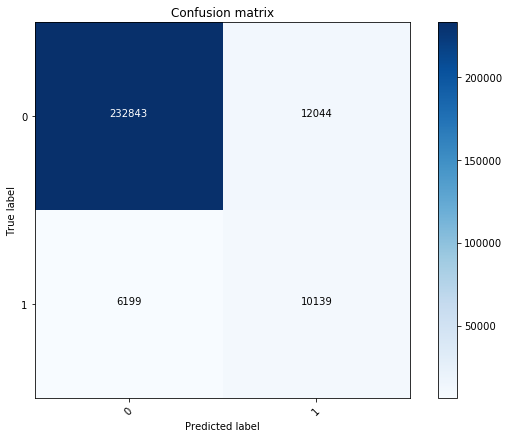

In [132]:
# Print graph of confusion matrix
#cm_bow = metrics.confusion_matrix(test_labels, prediction_bow, labels=[0,1])
plot_confusion_matrix(cm_bow, classes=['0','1'])

<module 'matplotlib.pyplot' from 'C:\\Users\\abhi\\Anaconda3\\envs\\tf_gpu_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

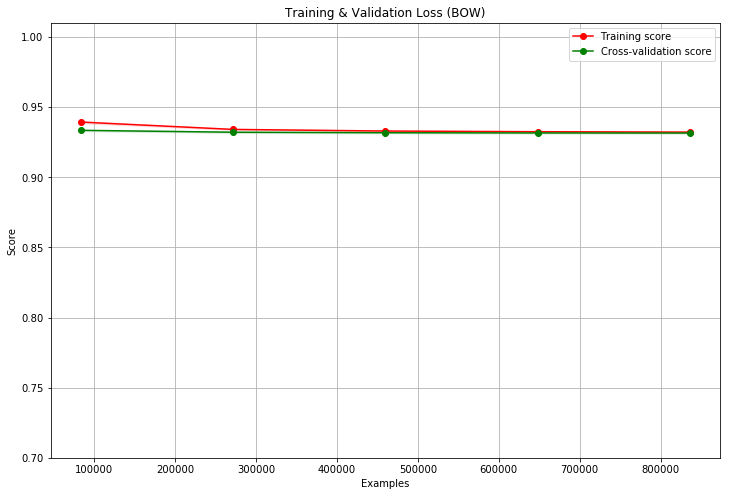

In [138]:
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(classifier_bow, 
                    "Training & Validation Loss (BOW)", 
                    train_questions_bow, 
                    train_targets, ylim=(0.7, 1.01), cv=cv, n_jobs=4)